In [1]:
%%HTML
<h1>Import Data</h1>

In [2]:
import pandas as pd
df1 = pd.read_csv('./data/210730_HNX_ALL.txt', sep = ',')
df2 = pd.read_csv('./data/210730_HOSE_ALL.txt', sep = ',')

frames = [df1, df2]
df = pd.concat(frames, ignore_index = True)
df.head()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,AAV,20210730,12.4,12.4,12.1,12.4,166400
1,ABT,20210730,26.0,27.2,26.0,27.1,1207
2,ACM,20210730,2.3,2.4,2.3,2.4,592463
3,ADC,20210730,21.5,21.5,21.5,21.5,0
4,ALT,20210730,12.7,12.7,12.7,12.7,0


In [3]:
%%HTML
<h1>Extract Data</h1>

In [4]:
# Remove redundant characters
df.columns=df.columns.str.replace('[<,>]','', regex=True)
df.head()

# Drop duplicate records
df_modified = df.drop_duplicates(subset = ['Ticker', 'DTYYYYMMDD'], keep = 'first')

# Change date data type
df_modified["DTYYYYMMDD"] = pd.to_datetime(df_modified["DTYYYYMMDD"], format='%Y%m%d')
df_modified.head()

,Ticker,DTYYYYMMDD,Open,High,Low,Close,Volume
0,AAV,2021-07-30,12.4,12.4,12.1,12.4,166400
1,ABT,2021-07-30,26.0,27.2,26.0,27.1,1207
2,ACM,2021-07-30,2.3,2.4,2.3,2.4,592463
3,ADC,2021-07-30,21.5,21.5,21.5,21.5,0
4,ALT,2021-07-30,12.7,12.7,12.7,12.7,0


In [5]:
#Pivot the table
pivot = df_modified.pivot(index='DTYYYYMMDD', columns='Ticker', values = 'Close')
pivot.head()

Ticker,AAA,AAM,AAT,AAV,ABS,ABT,ACB,ACC,ACL,ACM,...,VTJ,VTL,VTO,VTV,VXB,WCS,WSS,X20,YBM,YEG
DTYYYYMMDD,,,,,,,,,,,,,,,,,,,,,
2012-01-03,2.950,8.336,NaN,NaN,NaN,13.371,5.760,5.259,5.411,NaN,...,NaN,15.657,1.707,1.224,3.521,14.96,3.1,NaN,NaN,NaN
2012-01-04,2.976,8.487,NaN,NaN,NaN,13.409,5.760,5.289,5.349,NaN,...,NaN,15.657,1.707,1.269,3.521,14.96,2.9,NaN,NaN,NaN
2012-01-05,2.950,8.374,NaN,NaN,NaN,13.669,5.939,5.053,5.349,NaN,...,NaN,15.657,1.666,1.269,3.298,14.96,2.9,NaN,NaN,NaN
2012-01-06,2.925,8.374,NaN,NaN,NaN,13.036,5.819,5.289,5.349,NaN,...,NaN,15.657,1.626,1.269,3.164,14.96,2.8,NaN,NaN,NaN
2012-01-09,2.950,8.374,NaN,NaN,NaN,13.036,5.790,5.289,5.349,NaN,...,NaN,15.657,1.666,1.291,3.030,14.96,2.8,NaN,NaN,NaN


In [6]:
industry = pd.read_excel('./data/industry.xlsx', index_col=0)
industry.head()

,Value
Ticker,
AAA,Nhựa
AAM,Thủy sản
AAT,Thương mại
AAV,Thương mại
ABS,Sản xuất - Kinh doanh


In [7]:
%%HTML
<h1>Filter Data</h1>

In [8]:
%%HTML
<h3>We will slice the dataframe to small intervals of 3 months</h3>

In [9]:
data_list = []

import datetime
from datetime import timedelta

start_date = datetime.date(2015, 1, 1)
end_date = start_date

while end_date.year != 2019:
    end_date = start_date + datetime.timedelta(days=90)
    quarter = pivot.loc[start_date:end_date]
    data_list.append(quarter)
    start_date = end_date

In [10]:
%%HTML
<h1>Clean Data</h1>

In [11]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [12]:
def clean_data_func(data):
    # We shall remove all the columns with more than 20% of missing data
    missing_percentage = data.isnull().mean().sort_values(ascending=False)
    dropped_list = sorted(list(missing_percentage[missing_percentage > 0.2].index))
    data.drop(labels=dropped_list, axis=1, inplace=True)
    
    #Fill the remaining missing values with already available values
    data = data.fillna(method='ffill')
    data = data.fillna(method='bfill')
    return data

In [13]:
def returns_func(data):
    #Calculate percentage returns and create a data frame
    returns = data.pct_change()

    returns.replace([np.inf, -np.inf], np.nan, inplace=True)
    returns.dropna(inplace=True)
    
    return returns

In [14]:
def mean_returns_func(data):
    #Calculate mean returns and create a data frame
    mean_returns = data.pct_change().mean()*len(data)
    mean_returns = pd.DataFrame(mean_returns)
    mean_returns.columns = ['mean returns']

    #Calculate the volatility
    mean_returns['volatility'] = data.pct_change().std()*np.sqrt(len(data))
    
    return mean_returns

In [15]:
def industry_func(industry, mean_returns):
    industry_filter = industry
    for i in industry.index:
        if i not in mean_returns.index:
            industry_filter = industry_filter.drop(i)
    
    return industry_filter

In [16]:
def extract_pair(returns, clustered):
    clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
#     clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
    clustered_series = clustered_series[clustered_series != -1]
    
    CLUSTER_SIZE_LIMIT = 9999
    counts = clustered_series.value_counts()
    ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]

    cluster_dict = {}
    for i, which_clust in enumerate(ticker_count_reduced.index):
        tickers = clustered_series[clustered_series == which_clust].index
        score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(returns[tickers])
        cluster_dict[which_clust] = {}
        cluster_dict[which_clust]['score_matrix'] = score_matrix
        cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
        cluster_dict[which_clust]['pairs'] = pairs
    
    pairs = []
    for clust in cluster_dict.keys():
        pairs.extend(cluster_dict[clust]['pairs'])
    
    return pairs

In [17]:
def pair_rating(pairs, pair_dict):
    for pair in pairs:
        if pair in pair_dict:
            pair_dict[pair] = pair_dict[pair] + 1
        else:
            pair_dict[pair] = 1

In [18]:
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from statsmodels.tsa.stattools import coint

pd.options.mode.chained_assignment = None

pair_dict = {}

for data in data_list:
    data = clean_data_func(data)
    returns = returns_func(data)
    
    returns = returns.reset_index()
    returns = returns.drop(['DTYYYYMMDD'], axis=1)
    
    mean_returns = mean_returns_func(data)
    
    returns_trans = returns.transpose()
    
    industry_filter = industry_func(industry, mean_returns)
    industry1 = pd.get_dummies(industry_filter, columns = ['Value'])
        
    X = np.hstack((returns_trans, mean_returns, industry1))
    
    X = preprocessing.StandardScaler().fit_transform(X)

    clf = DBSCAN(eps=5.5, min_samples=3)
    clf.fit(X)
    clustered = clf.labels_
    
    pairs = extract_pair(returns, clustered)
    pair_rating(pairs, pair_dict)

print(pair_dict)

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
 

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
 

{('CAV', 'DHC'): 3, ('CAV', 'DHP'): 3, ('CAV', 'GMC'): 2, ('CAV', 'HAG'): 3, ('CAV', 'HAP'): 1, ('CAV', 'KBC'): 2, ('CAV', 'KDH'): 2, ('CAV', 'KMR'): 1, ('CAV', 'LIX'): 2, ('CAV', 'MHL'): 2, ('CAV', 'NLG'): 3, ('CAV', 'PAC'): 3, ('CAV', 'PDR'): 2, ('CAV', 'REE'): 3, ('CAV', 'SDN'): 1, ('CAV', 'SHI'): 1, ('CAV', 'TCM'): 3, ('CAV', 'TLG'): 1, ('CAV', 'TYA'): 1, ('CAV', 'VIC'): 3, ('ACB', 'BVH'): 10, ('ACB', 'DIG'): 7, ('ACB', 'DPM'): 16, ('ACB', 'EIB'): 9, ('ACB', 'GMD'): 11, ('ACB', 'HPG'): 13, ('ACB', 'KDC'): 14, ('ACB', 'MBB'): 16, ('ACB', 'MSN'): 12, ('ACB', 'PVT'): 11, ('ACB', 'SHB'): 14, ('ACB', 'STB'): 10, ('ACB', 'VCB'): 14, ('ACB', 'VCS'): 5, ('ACB', 'VNM'): 14, ('ACB', 'VSH'): 15, ('BII', 'DLG'): 2, ('BII', 'HAR'): 1, ('BII', 'HQC'): 2, ('BII', 'ITA'): 2, ('BII', 'ITC'): 1, ('BII', 'LCG'): 1, ('BII', 'NBB'): 1, ('BII', 'NTL'): 1, ('BII', 'QCG'): 1, ('BII', 'SCR'): 2, ('BII', 'SJS'): 1, ('BII', 'SZL'): 1, ('BII', 'TDH'): 1, ('BTP', 'CNG'): 7, ('BTP', 'DRL'): 6, ('BTP', 'KHP'): 8

In [19]:
for pair in pair_dict:
    if pair_dict[pair] > 6:
        print(pair, pair_dict[pair])

('ACB', 'BVH') 10
('ACB', 'DIG') 7
('ACB', 'DPM') 16
('ACB', 'EIB') 9
('ACB', 'GMD') 11
('ACB', 'HPG') 13
('ACB', 'KDC') 14
('ACB', 'MBB') 16
('ACB', 'MSN') 12
('ACB', 'PVT') 11
('ACB', 'SHB') 14
('ACB', 'STB') 10
('ACB', 'VCB') 14
('ACB', 'VNM') 14
('ACB', 'VSH') 15
('BTP', 'CNG') 7
('BTP', 'KHP') 8
('BTP', 'PGC') 9
('BTP', 'PPC') 7
('BTP', 'PVG') 7
('BTP', 'SBA') 8
('BTP', 'SJD') 9
('BDB', 'DAE') 7
('ACB', 'BID') 12
('ACB', 'CTG') 15
('ACB', 'DCM') 14
('ACB', 'PNJ') 10
('GAS', 'PVD') 8
('GAS', 'PVS') 7
('ACB', 'MWG') 9
('ACB', 'NT2') 11
('CSM', 'DPR') 8
('CSM', 'DRC') 8
('CSM', 'TRC') 8
('ACB', 'PVI') 11
('ASM', 'LHC') 7
('DTL', 'PPE') 7
('CLM', 'FPT') 8
('CLM', 'PET') 8
('ACC', 'NNC') 7


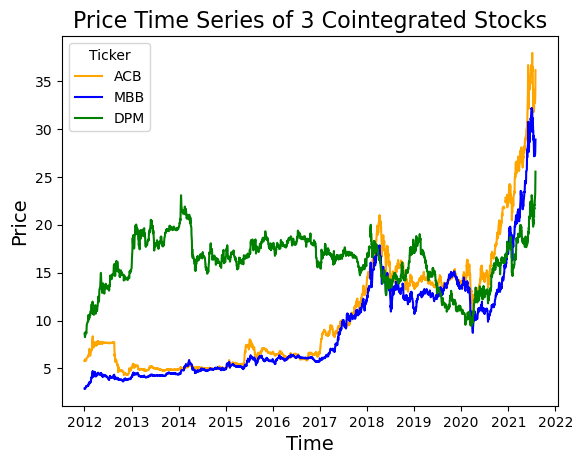

In [20]:
import matplotlib.pyplot as plt
# plot each series
plt.plot(pivot['ACB'], label='ACB', color='orange')
plt.plot(pivot['MBB'], label='MBB', color='blue')
plt.plot(pivot['DPM'], label='DPM', color='green')
plt.legend(title='Ticker')

#add axes labels and a title
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Price Time Series of 3 Cointegrated Stocks', fontsize=16)

#display plot
plt.show()